In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D

# 수위 결측치 처리 - CNN/LSTM

In [3]:
강화대교_시간차 = pd.read_csv('data/파생컬럼/강화대교_조위_시간차.csv', encoding = 'cp949')

In [4]:
방류량_시간차 = pd.read_csv('data/파생컬럼/방류량_시간차.csv', encoding = 'cp949')

In [5]:
raw_data = pd.read_csv('data/newdata.csv', encoding = 'cp949')
rawdata_ = pd.concat([방류량_시간차, 강화대교_시간차, raw_data[['날짜','강수량(mm)','청담대교_유량','한강대교_유량','행주대교_유량','광진교_수위','청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]], axis=1)
rawdata_.날짜 = pd.to_datetime(rawdata_.날짜)
raw_data = rawdata_.set_index('날짜')
raw_data

,방류량,강화대교_조위,강수량(mm),청담대교_유량,한강대교_유량,행주대교_유량,광진교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,
2012-05-01 00:00:00,575.70,193.0,0.0,469.05,729.80,540.18,1.20,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,575.30,199.0,0.0,498.00,731.48,540.18,1.20,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,555.00,207.0,0.0,490.68,726.42,540.18,1.20,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,575.70,215.0,0.0,476.21,726.42,552.17,1.20,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,575.40,226.0,0.0,476.21,707.17,564.29,1.20,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,258.67,407.0,0.0,319.84,-456.41,974.40,1.12,288.0,295.0,299.0,306.0
2022-07-18 23:20:00,258.58,431.0,0.0,314.01,-717.30,1006.88,1.12,287.0,303.0,304.0,308.0
2022-07-18 23:30:00,258.56,453.0,0.0,387.55,-843.37,1039.90,1.12,299.0,307.0,309.0,310.0


In [5]:
raw_data.isnull().sum()

방류량        0
강화대교_조위    0
강수량(mm)    0
청담대교_유량    0
한강대교_유량    0
행주대교_유량    0
광진교_수위     0
청담대교_수위    0
잠수교_수위     0
한강대교_수위    0
행주대교_수위    0
dtype: int64

In [7]:
xdata = raw_data
xdata

,방류량,강화대교_조위,강수량(mm),청담대교_유량,한강대교_유량,행주대교_유량,광진교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,
2012-05-01 00:00:00,575.70,193.0,0.0,469.05,729.80,540.18,1.20,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,575.30,199.0,0.0,498.00,731.48,540.18,1.20,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,555.00,207.0,0.0,490.68,726.42,540.18,1.20,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,575.70,215.0,0.0,476.21,726.42,552.17,1.20,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,575.40,226.0,0.0,476.21,707.17,564.29,1.20,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,258.67,407.0,0.0,319.84,-456.41,974.40,1.12,288.0,295.0,299.0,306.0
2022-07-18 23:20:00,258.58,431.0,0.0,314.01,-717.30,1006.88,1.12,287.0,303.0,304.0,308.0
2022-07-18 23:30:00,258.56,453.0,0.0,387.55,-843.37,1039.90,1.12,299.0,307.0,309.0,310.0


In [8]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

In [9]:
input_x_regular = input_x_regular.reset_index()
input_x_regular = input_x_regular[['방류량','강화대교_조위','강수량(mm)','청담대교_유량','한강대교_유량','행주대교_유량','광진교_수위','청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x_regular = pd.DataFrame(input_x_regular)
input_x_regular

,방류량,강화대교_조위,강수량(mm),청담대교_유량,한강대교_유량,행주대교_유량,광진교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0.058462,0.191781,0.0,0.110974,0.147596,0.011070,0.056452,0.049611,0.085356,0.063981,0.056478
1,0.058447,0.199253,0.0,0.112074,0.147654,0.011070,0.056452,0.053502,0.085356,0.063981,0.056478
2,0.057689,0.209215,0.0,0.111796,0.147478,0.011070,0.056452,0.052529,0.086437,0.063981,0.056478
3,0.058462,0.219178,0.0,0.111246,0.147478,0.011475,0.056452,0.050584,0.086437,0.063981,0.058140
4,0.058451,0.232877,0.0,0.111246,0.146810,0.011883,0.056452,0.050584,0.086437,0.065166,0.059801
...,...,...,...,...,...,...,...,...,...,...,...
276331,0.046624,0.458281,0.0,0.105305,0.106425,0.025719,0.045699,0.027529,0.079734,0.074645,0.107475
276332,0.046621,0.488169,0.0,0.105084,0.097370,0.026815,0.045699,0.026556,0.088383,0.080569,0.110797
276333,0.046620,0.515567,0.0,0.107878,0.092994,0.027929,0.045699,0.038230,0.092708,0.086493,0.114120
276334,0.046624,0.544209,0.0,0.110437,0.086747,0.029061,0.045699,0.047957,0.097032,0.092417,0.117442


In [31]:
newdata = pd.read_csv('data/rawdata.csv')
ydata = newdata[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]

In [32]:
ydata = ydata.reset_index()
ydata = ydata[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
ydata = pd.DataFrame(ydata)
ydata

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,310.7,300.2,290.0,275.3
1,314.7,300.2,290.0,275.3
2,313.7,301.2,290.0,275.3
3,311.7,301.2,290.0,276.3
4,311.7,301.2,291.0,277.3
...,...,...,...,...
276331,0.0,0.0,0.0,0.0
276332,0.0,0.0,0.0,0.0
276333,0.0,0.0,0.0,0.0
276334,0.0,0.0,0.0,0.0


In [33]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,방류량,강화대교_조위,강수량(mm),청담대교_유량,한강대교_유량,행주대교_유량,광진교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0.058462,0.191781,0.0,0.110974,0.147596,0.011070,0.056452,0.049611,0.085356,0.063981,0.056478,310.7,300.2,290.0,275.3
1,0.058447,0.199253,0.0,0.112074,0.147654,0.011070,0.056452,0.053502,0.085356,0.063981,0.056478,314.7,300.2,290.0,275.3
2,0.057689,0.209215,0.0,0.111796,0.147478,0.011070,0.056452,0.052529,0.086437,0.063981,0.056478,313.7,301.2,290.0,275.3
3,0.058462,0.219178,0.0,0.111246,0.147478,0.011475,0.056452,0.050584,0.086437,0.063981,0.058140,311.7,301.2,290.0,276.3
4,0.058451,0.232877,0.0,0.111246,0.146810,0.011883,0.056452,0.050584,0.086437,0.065166,0.059801,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,0.046624,0.458281,0.0,0.105305,0.106425,0.025719,0.045699,0.027529,0.079734,0.074645,0.107475,0.0,0.0,0.0,0.0
276332,0.046621,0.488169,0.0,0.105084,0.097370,0.026815,0.045699,0.026556,0.088383,0.080569,0.110797,0.0,0.0,0.0,0.0
276333,0.046620,0.515567,0.0,0.107878,0.092994,0.027929,0.045699,0.038230,0.092708,0.086493,0.114120,0.0,0.0,0.0,0.0
276334,0.046624,0.544209,0.0,0.110437,0.086747,0.029061,0.045699,0.047957,0.097032,0.092417,0.117442,0.0,0.0,0.0,0.0


In [34]:
input_regular.isnull().sum()

방류량         0
강화대교_조위     0
강수량(mm)     0
청담대교_유량     0
한강대교_유량     0
행주대교_유량     0
광진교_수위      0
청담대교_수위     0
잠수교_수위      0
한강대교_수위     0
행주대교_수위     0
청담대교_수위    59
잠수교_수위     59
한강대교_수위    59
행주대교_수위    59
dtype: int64

In [35]:
idx = ydata[ydata['청담대교_수위'].isnull()==True]['청담대교_수위'].index
idx

Int64Index([140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620,
            140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628,
            140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636,
            140637, 140638, 140639, 140640, 140641, 140642, 140643, 140644,
            140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652,
            140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660,
            140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668,
            140669, 140670, 236080],
           dtype='int64')

In [36]:
nanIndex = idx

In [37]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-len(ydata_idx)):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [05:40<00:00, 30.91s/it]


In [38]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276270, 6, 11)
(276270, 4)


In [39]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [40]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(59, 6, 11)
(59, 4)


In [41]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276211, 6, 11)
(276211, 4)


In [42]:
pd.DataFrame(ydata).isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

In [45]:
xtrain = np.array(xdata[:-40000])
ytrain = np.array(ydata[:-40000])

xtest = np.array(xdata[-40000:])
ytest = np.array(ydata[-40000:])

In [46]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(236211, 6, 11)
(236211, 4)
(40000, 6, 11)
(40000, 4)


## 모델 생성

In [47]:
def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(4))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             1472      
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 384)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 200)            468000    
                                                                 
 lstm_1 (LSTM)               (None, 1, 200)            320800    
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                        

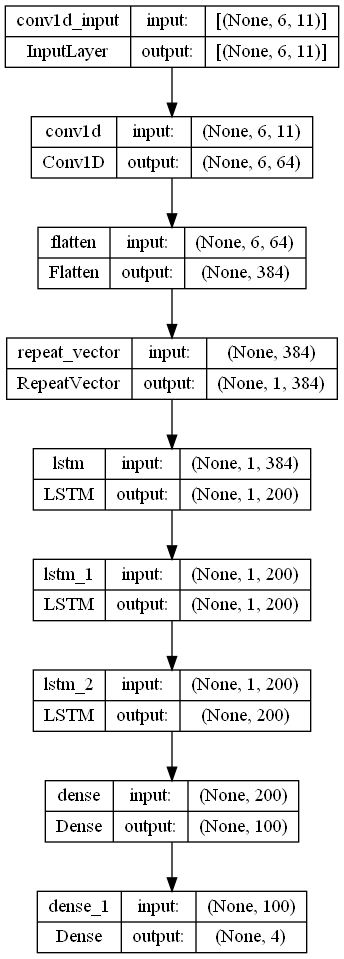

In [48]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [49]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

In [50]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
801/801 [==============================] - 36s 29ms/step - loss: 25.2325 - nse: 0.4868 - val_loss: 32.6139 - val_nse: -0.8678 - lr: 0.0100
Epoch 2/100
801/801 [==============================] - 15s 18ms/step - loss: 15.0058 - nse: 0.9006 - val_loss: 15.3824 - val_nse: 0.4907 - lr: 0.0100
Epoch 3/100
801/801 [==============================] - 15s 19ms/step - loss: 10.9921 - nse: 0.9599 - val_loss: 10.6933 - val_nse: 0.7527 - lr: 0.0100
Epoch 4/100
801/801 [==============================] - 15s 19ms/step - loss: 6.9819 - nse: 0.9827 - val_loss: 11.5242 - val_nse: 0.7154 - lr: 0.0100
Epoch 5/100
801/801 [==============================] - 15s 18ms/step - loss: 7.2383 - nse: 0.9816 - val_loss: 8.1153 - val_nse: 0.8449 - lr: 0.0100
Epoch 6/100
801/801 [==============================] - 15s 18ms/step - loss: 6.6236 - nse: 0.9851 - val_loss: 10.8048 - val_nse: 0.7580 - lr: 0.0100
Epoch 7/100
801/801 [==============================] - 15s 19ms/step - loss: 6.0728 - nse: 0.9876 - val

In [51]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse':nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

1250/1250 [==============================] - 8s 6ms/step - loss: 56.6705 - nse: -inf


[56.67051696777344, -inf]

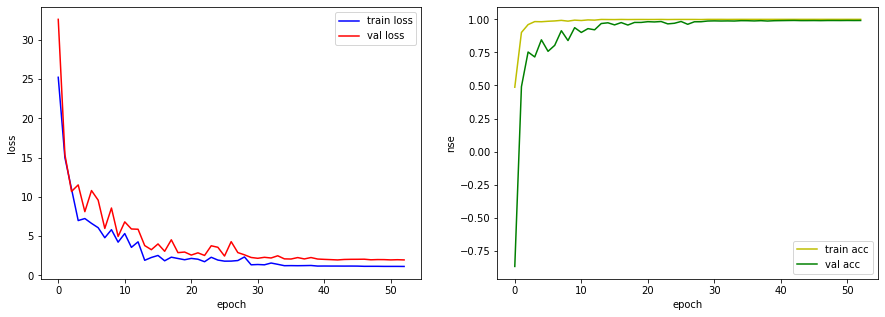

In [52]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

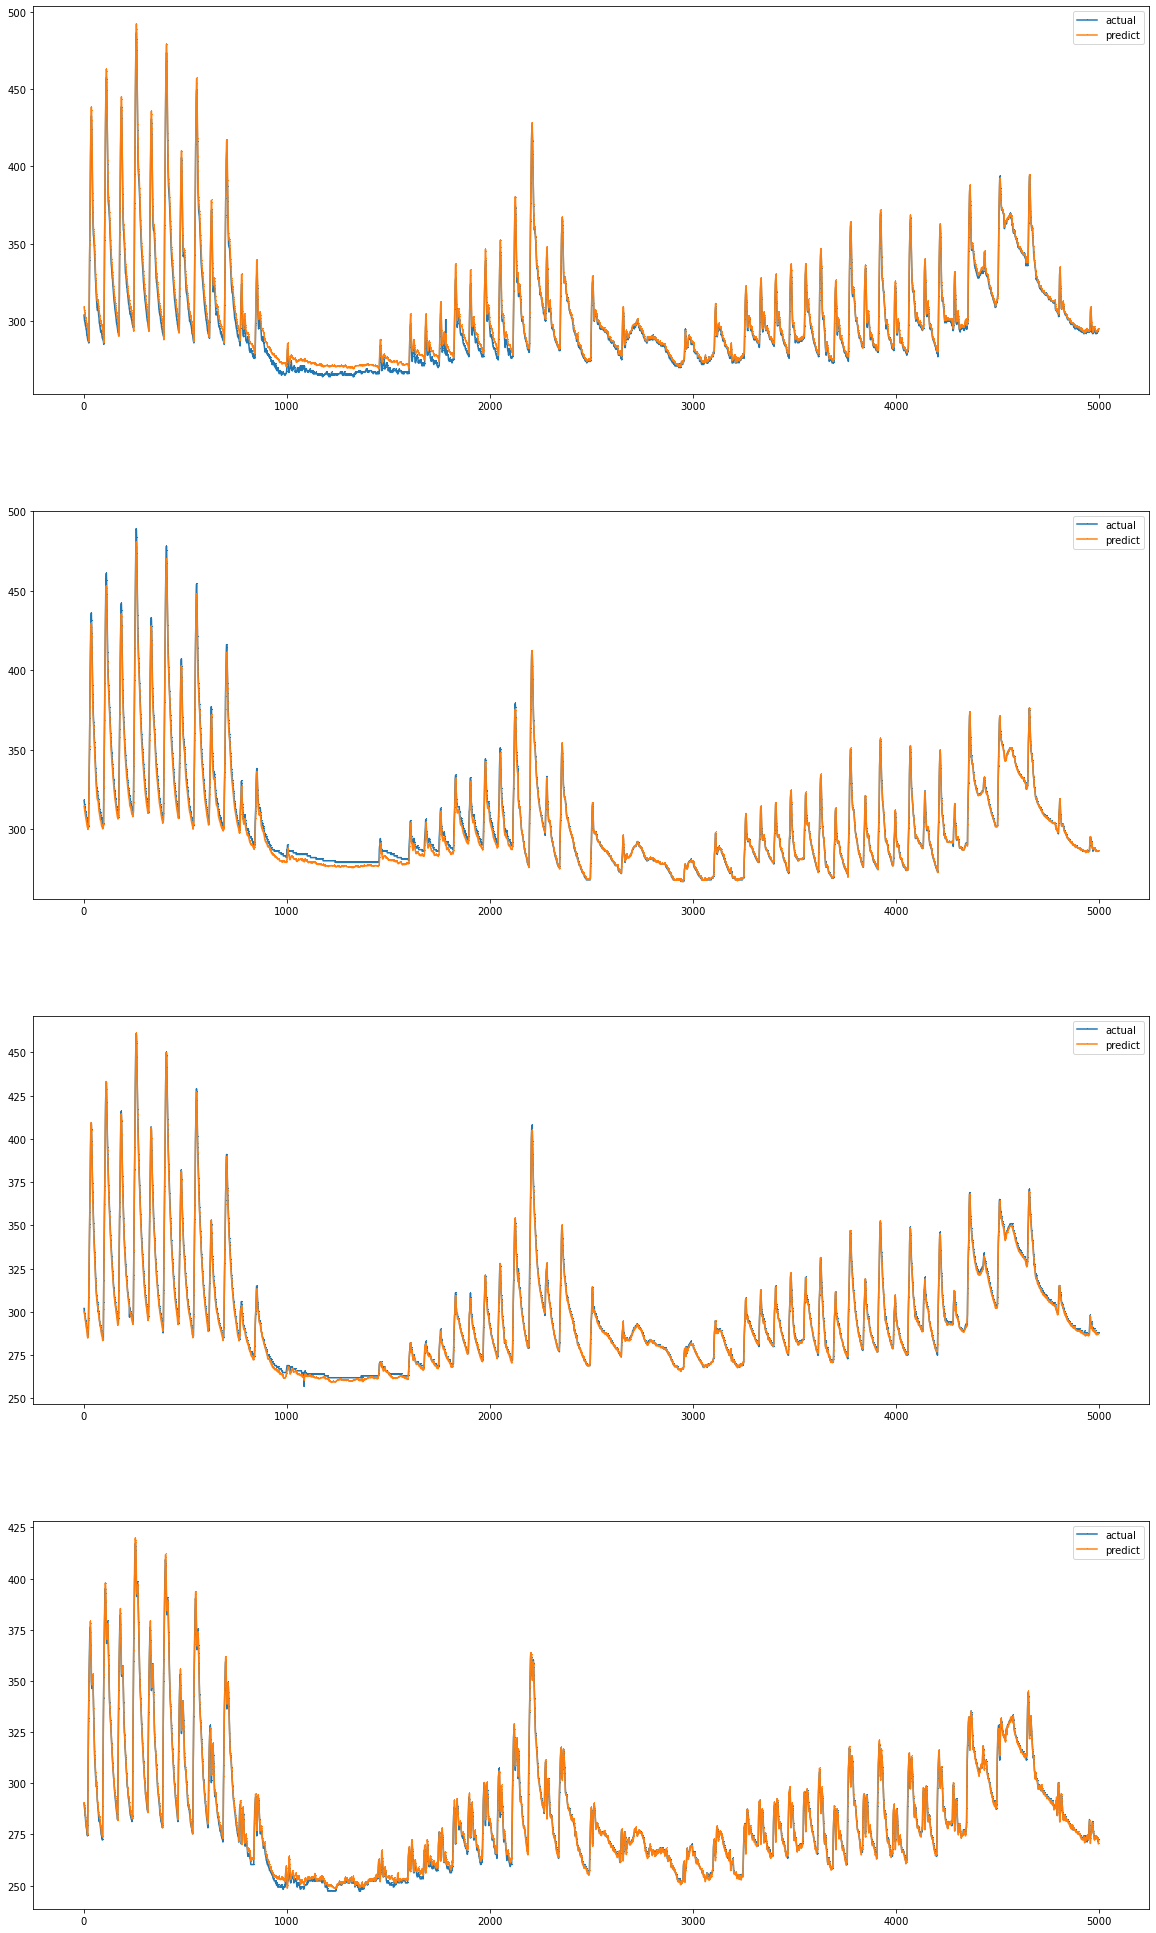

In [53]:
## 결과 시각화
tl_predict = np.array(yhat)

f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest.T[i][:5000], marker = ",", label = "actual")
    axes[i].plot(tl_predict.T[i][:5000], marker = ",", label="predict", alpha = 0.98)
    axes[i].legend(prop={'size':10})  

plt.show()

In [54]:
## 점수 확인
float(root_mean_squared_error(ytest, tl_predict))

137.31236884493953

## 파일 저장

In [55]:
raw_data2 = pd.read_csv('data/rawdata.csv')
raw_data2 = raw_data2[:-6912]
predict_dataset = raw_data2[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]

In [56]:
predict_dataset.isnull().sum()

청담대교_수위    59
잠수교_수위     59
한강대교_수위    59
행주대교_수위    59
dtype: int64

In [57]:
predict_dataset.iloc[nanIndex[2]]

청담대교_수위   NaN
잠수교_수위    NaN
한강대교_수위   NaN
행주대교_수위   NaN
Name: 140615, dtype: float64

In [58]:
y_real_predict

[array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan, nan, nan]),
 array([na

In [59]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

2/2 [==============================] - 0s 7ms/step


In [60]:
y_real_hat

array([[424.73993, 406.3282 , 404.5109 , 375.35168],
       [420.5452 , 402.14648, 401.31046, 374.877  ],
       [418.32318, 399.58258, 399.20224, 373.61975],
       [416.92227, 397.8596 , 397.35327, 370.80142],
       [415.70172, 395.74542, 395.16537, 368.09332],
       [414.19827, 393.13263, 392.4992 , 365.29272],
       [412.4765 , 390.27866, 389.4913 , 362.25345],
       [410.74026, 387.2948 , 386.40976, 359.11398],
       [408.961  , 384.16974, 383.40512, 355.90372],
       [407.28024, 381.05783, 380.33905, 352.72357],
       [405.55014, 377.95227, 377.232  , 349.8507 ],
       [403.741  , 375.00427, 374.1642 , 346.9614 ],
       [401.80222, 372.06696, 371.13715, 344.12842],
       [399.87466, 369.05707, 368.2017 , 341.4797 ],
       [397.92114, 366.0249 , 365.27   , 339.0295 ],
       [395.9979 , 362.9747 , 362.36676, 336.70166],
       [394.03992, 359.92148, 359.51434, 334.54562],
       [392.03394, 357.12494, 356.712  , 332.55148],
       [389.99493, 354.34445, 353.91977, 330.6

In [61]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269424 entries, 0 to 269423
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   청담대교_수위  269365 non-null  float64
 1   잠수교_수위   269365 non-null  float64
 2   한강대교_수위  269365 non-null  float64
 3   행주대교_수위  269365 non-null  float64
dtypes: float64(4)
memory usage: 8.2 MB


In [63]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [65]:
addon = pd.read_csv('data/newdata.csv', encoding = 'cp949')
addon.set_index(keys = ['날짜'], inplace = True)
addon.index = pd.to_datetime(addon.index, format = '%Y-%m-%d %H:%M')
add = addon[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']][-6912:]
add

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,
2022-06-01 00:00:00,279.0,276.0,274.0,269.0
2022-06-01 00:10:00,281.0,277.0,274.0,267.0
2022-06-01 00:20:00,284.0,277.0,274.0,264.0
2022-06-01 00:30:00,285.0,277.0,274.0,261.0
2022-06-01 00:40:00,284.0,278.0,274.0,259.0
...,...,...,...,...
2022-07-18 23:10:00,288.0,295.0,299.0,306.0
2022-07-18 23:20:00,287.0,303.0,304.0,308.0
2022-07-18 23:30:00,299.0,307.0,309.0,310.0


In [66]:
result = pd.concat([predict_dataset,add], ignore_index=True)
result

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,310.7,300.2,290.0,275.3
1,314.7,300.2,290.0,275.3
2,313.7,301.2,290.0,275.3
3,311.7,301.2,290.0,276.3
4,311.7,301.2,291.0,277.3
...,...,...,...,...
276331,288.0,295.0,299.0,306.0
276332,287.0,303.0,304.0,308.0
276333,299.0,307.0,309.0,310.0
276334,309.0,311.0,314.0,312.0


In [67]:
result.to_csv('data/수위x4.csv', index = False, encoding = 'cp949', columns = ['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위'])

# 수위 외 결측치 처리 - 행주대교 유량

In [6]:
raw_data = pd.read_csv('data/수위x4.csv', encoding = 'cp949')
raw_data

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,310.7,300.2,290.0,275.3
1,314.7,300.2,290.0,275.3
2,313.7,301.2,290.0,275.3
3,311.7,301.2,290.0,276.3
4,311.7,301.2,291.0,277.3
...,...,...,...,...
276331,288.0,295.0,299.0,306.0
276332,287.0,303.0,304.0,308.0
276333,299.0,307.0,309.0,310.0
276334,309.0,311.0,314.0,312.0


In [7]:
raw_data2 = pd.read_csv('data/newdata.csv', encoding = 'cp949')

In [155]:
raw_data2

,Unnamed: 0,날짜,강수량(mm),방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,광진교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0,2012-05-01 00:00:00,0.0,555.00,445.0,469.05,729.80,540.18,1.20,310.7,300.2,290.0,275.3
1,1,2012-05-01 00:10:00,0.0,562.90,449.0,498.00,731.48,540.18,1.20,314.7,300.2,290.0,275.3
2,2,2012-05-01 00:20:00,0.0,576.40,451.0,490.68,726.42,540.18,1.20,313.7,301.2,290.0,275.3
3,3,2012-05-01 00:30:00,0.0,563.10,452.0,476.21,726.42,552.17,1.20,311.7,301.2,290.0,276.3
4,4,2012-05-01 00:40:00,0.0,576.40,450.0,476.21,707.17,564.29,1.20,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,276331,2022-07-18 23:10:00,0.0,259.23,510.0,319.84,-456.41,974.40,1.12,288.0,295.0,299.0,306.0
276332,276332,2022-07-18 23:20:00,0.0,260.46,492.0,314.01,-717.30,1006.88,1.12,287.0,303.0,304.0,308.0
276333,276333,2022-07-18 23:30:00,0.0,259.37,475.0,387.55,-843.37,1039.90,1.12,299.0,307.0,309.0,310.0
276334,276334,2022-07-18 23:40:00,0.0,259.13,458.0,454.91,-1023.37,1073.46,1.12,309.0,311.0,314.0,312.0


In [156]:
xdata = pd.concat([raw_data,raw_data2[['강수량(mm)','방류량','강화대교_조위','청담대교_유량','한강대교_유량','행주대교_유량']]], axis = 1)
xdata

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량
0,310.7,300.2,290.0,275.3,0.0,555.00,445.0,469.05,729.80,540.18
1,314.7,300.2,290.0,275.3,0.0,562.90,449.0,498.00,731.48,540.18
2,313.7,301.2,290.0,275.3,0.0,576.40,451.0,490.68,726.42,540.18
3,311.7,301.2,290.0,276.3,0.0,563.10,452.0,476.21,726.42,552.17
4,311.7,301.2,291.0,277.3,0.0,576.40,450.0,476.21,707.17,564.29
...,...,...,...,...,...,...,...,...,...,...
276331,288.0,295.0,299.0,306.0,0.0,259.23,510.0,319.84,-456.41,974.40
276332,287.0,303.0,304.0,308.0,0.0,260.46,492.0,314.01,-717.30,1006.88
276333,299.0,307.0,309.0,310.0,0.0,259.37,475.0,387.55,-843.37,1039.90
276334,309.0,311.0,314.0,312.0,0.0,259.13,458.0,454.91,-1023.37,1073.46


In [157]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

In [158]:
input_x_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량
0,0.049611,0.060000,0.051621,0.056478,0.0,0.057689,0.118382,0.110974,0.147596,0.011070
1,0.053502,0.060000,0.051621,0.056478,0.0,0.057984,0.118713,0.112074,0.147654,0.011070
2,0.052529,0.061111,0.051621,0.056478,0.0,0.058488,0.118878,0.111796,0.147478,0.011070
3,0.050584,0.061111,0.051621,0.058140,0.0,0.057992,0.118961,0.111246,0.147478,0.011475
4,0.050584,0.061111,0.052821,0.059801,0.0,0.058488,0.118795,0.111246,0.146810,0.011883
...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.046645,0.123758,0.105305,0.106425,0.025719
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.046691,0.122269,0.105084,0.097370,0.026815
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.046650,0.120863,0.107878,0.092994,0.027929
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.046642,0.119457,0.110437,0.086747,0.029061


In [159]:
newdata = pd.read_csv('data/rawdata.csv')
ydata = newdata[['행주대교_유량']]
ydata

,행주대교_유량
0,540.18
1,540.18
2,540.18
3,552.17
4,564.29
...,...
276331,974.40
276332,1006.88
276333,1039.90
276334,1073.46


In [160]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,행주대교_유량
0,0.049611,0.060000,0.051621,0.056478,0.0,0.057689,0.118382,0.110974,0.147596,0.011070,540.18
1,0.053502,0.060000,0.051621,0.056478,0.0,0.057984,0.118713,0.112074,0.147654,0.011070,540.18
2,0.052529,0.061111,0.051621,0.056478,0.0,0.058488,0.118878,0.111796,0.147478,0.011070,540.18
3,0.050584,0.061111,0.051621,0.058140,0.0,0.057992,0.118961,0.111246,0.147478,0.011475,552.17
4,0.050584,0.061111,0.052821,0.059801,0.0,0.058488,0.118795,0.111246,0.146810,0.011883,564.29
...,...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.046645,0.123758,0.105305,0.106425,0.025719,974.40
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.046691,0.122269,0.105084,0.097370,0.026815,1006.88
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.046650,0.120863,0.107878,0.092994,0.027929,1039.90
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.046642,0.119457,0.110437,0.086747,0.029061,1073.46


In [161]:
input_regular.isnull().sum()

청담대교_수위     0
잠수교_수위      0
한강대교_수위     0
행주대교_수위     0
강수량(mm)     0
방류량         0
강화대교_조위     0
청담대교_유량     0
한강대교_유량     0
행주대교_유량     0
행주대교_유량    59
dtype: int64

In [162]:
idx = ydata[ydata['행주대교_유량'].isnull()==True]['행주대교_유량'].index
idx

Int64Index([140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620,
            140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628,
            140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636,
            140637, 140638, 140639, 140640, 140641, 140642, 140643, 140644,
            140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652,
            140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660,
            140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668,
            140669, 140670, 236080],
           dtype='int64')

In [163]:
nanIndex = idx

In [164]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-len(ydata_idx)):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:42<00:00,  9.34s/it]


In [165]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276270, 6, 10)
(276270, 1)


In [166]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [167]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(59, 6, 10)
(59, 1)


In [168]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276211, 6, 10)
(276211, 1)


In [169]:
pd.DataFrame(ydata).isnull().sum()

0    0
dtype: int64

In [170]:
xtrain = np.array(xdata[:-40000])
ytrain = np.array(ydata[:-40000])

xtest = np.array(xdata[-40000:])
ytest = np.array(ydata[-40000:])

In [171]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(236211, 6, 10)
(236211, 1)
(40000, 6, 10)
(40000, 1)


## 모델 생성

In [172]:
def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 6, 64)             1344      
                                                                 
 flatten_5 (Flatten)         (None, 384)               0         
                                                                 
 repeat_vector_5 (RepeatVect  (None, 1, 384)           0         
 or)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 1, 200)            468000    
                                                                 
 lstm_16 (LSTM)              (None, 1, 200)            320800    
                                                                 
 lstm_17 (LSTM)              (None, 200)               320800    
                                                      

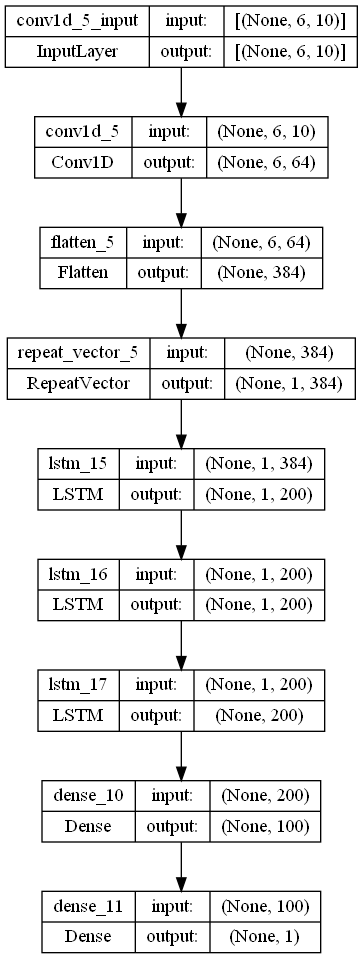

In [173]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [174]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

In [175]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
801/801 [==============================] - 18s 18ms/step - loss: 162.4066 - nse: 0.9467 - val_loss: 78.5023 - val_nse: 0.9487 - lr: 0.0100
Epoch 2/100
801/801 [==============================] - 15s 19ms/step - loss: 89.5783 - nse: 0.9913 - val_loss: 115.9510 - val_nse: 0.2958 - lr: 0.0100
Epoch 3/100
801/801 [==============================] - 15s 19ms/step - loss: 71.5440 - nse: 0.9942 - val_loss: 63.2843 - val_nse: 0.6503 - lr: 0.0100
Epoch 4/100
801/801 [==============================] - 15s 19ms/step - loss: 65.0093 - nse: 0.9950 - val_loss: 39.3598 - val_nse: 0.9011 - lr: 0.0100
Epoch 5/100
801/801 [==============================] - 15s 18ms/step - loss: 59.9563 - nse: 0.9959 - val_loss: 59.3411 - val_nse: 0.8528 - lr: 0.0100
Epoch 6/100
801/801 [==============================] - 15s 19ms/step - loss: 58.3447 - nse: 0.9964 - val_loss: 65.5691 - val_nse: 0.9026 - lr: 0.0100
Epoch 7/100
801/801 [==============================] - 15s 19ms/step - loss: 50.1637 - nse: 0.9974

In [176]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse':nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

1250/1250 [==============================] - 6s 5ms/step - loss: 14.9694 - nse: -inf


[14.969429969787598, -inf]

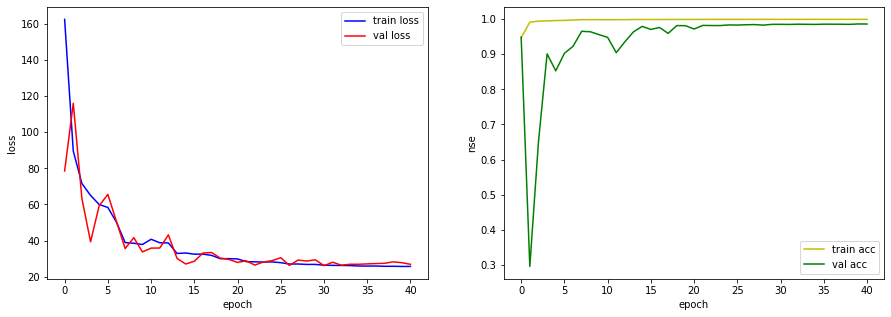

In [177]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

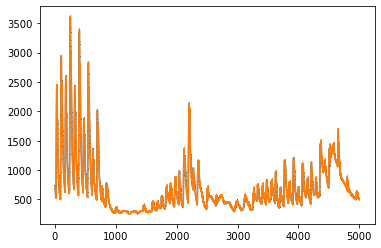

In [180]:
## 결과 시각화
tl_predict = np.array(yhat)

plt.plot(ytest.T[i][:5000], marker = ",", label = "actual")
plt.plot(tl_predict.T[i][:5000], marker = ",", label="predict", alpha = 0.98)
 

plt.show()

In [181]:
## 점수 확인
float(root_mean_squared_error(ytest, tl_predict))

17.68385455392392

## 파일 저장

In [184]:
raw_data2 = pd.read_csv('data/rawdata.csv')
predict_dataset = raw_data2[['행주대교_유량']]

In [185]:
predict_dataset.isnull().sum()

행주대교_유량    59
dtype: int64

In [186]:
predict_dataset.iloc[nanIndex[2]]

행주대교_유량   NaN
Name: 140615, dtype: float64

In [187]:
y_real_predict

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan])]

In [188]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

2/2 [==============================] - 0s 10ms/step


In [189]:
y_real_hat

array([[2439.838 ],
       [2440.4177],
       [2399.834 ],
       [2345.3313],
       [2272.5444],
       [2224.065 ],
       [2177.336 ],
       [2121.8394],
       [2059.6719],
       [1994.0306],
       [1929.5526],
       [1872.975 ],
       [1818.8434],
       [1766.4023],
       [1716.6526],
       [1669.6415],
       [1624.6776],
       [1583.9279],
       [1546.3085],
       [1511.7831],
       [1483.6405],
       [1456.6698],
       [1428.4672],
       [1403.5266],
       [1378.2181],
       [1344.2498],
       [1323.548 ],
       [1306.8058],
       [1292.2296],
       [1277.3247],
       [1264.3145],
       [1270.3572],
       [1265.8068],
       [1255.3026],
       [1246.2451],
       [1236.8726],
       [1241.9313],
       [1258.9186],
       [1259.5758],
       [1242.0461],
       [1228.9823],
       [1234.1709],
       [1294.7225],
       [1347.2902],
       [1360.8513],
       [1369.8529],
       [1374.5679],
       [1387.0878],
       [1418.1547],
       [1445.493 ],


In [190]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   행주대교_유량  276277 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [191]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [195]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   행주대교_유량  276336 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [196]:
predict_dataset.to_csv('data/행주대교_유량.csv', index = False, encoding = 'cp949', columns = ['행주대교_유량'])

# 수위 외 결측치 처리 - 방류량

In [8]:
raw_data3 = pd.read_csv('data/행주대교_유량.csv', encoding = 'cp949')
raw_data3

,행주대교_유량
0,540.18
1,540.18
2,540.18
3,552.17
4,564.29
...,...
276331,974.40
276332,1006.88
276333,1039.90
276334,1073.46


In [201]:
xdata = pd.concat([raw_data,raw_data2[['강수량(mm)','방류량','강화대교_조위','청담대교_유량','한강대교_유량']],raw_data3], axis = 1)
xdata

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량
0,310.7,300.2,290.0,275.3,0.0,555.00,445.0,469.05,729.80,540.18
1,314.7,300.2,290.0,275.3,0.0,562.90,449.0,498.00,731.48,540.18
2,313.7,301.2,290.0,275.3,0.0,576.40,451.0,490.68,726.42,540.18
3,311.7,301.2,290.0,276.3,0.0,563.10,452.0,476.21,726.42,552.17
4,311.7,301.2,291.0,277.3,0.0,576.40,450.0,476.21,707.17,564.29
...,...,...,...,...,...,...,...,...,...,...
276331,288.0,295.0,299.0,306.0,0.0,259.23,510.0,319.84,-456.41,974.40
276332,287.0,303.0,304.0,308.0,0.0,260.46,492.0,314.01,-717.30,1006.88
276333,299.0,307.0,309.0,310.0,0.0,259.37,475.0,387.55,-843.37,1039.90
276334,309.0,311.0,314.0,312.0,0.0,259.13,458.0,454.91,-1023.37,1073.46


In [202]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

In [203]:
input_x_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량
0,0.049611,0.060000,0.051621,0.056478,0.0,0.057689,0.118382,0.110974,0.147596,0.011070
1,0.053502,0.060000,0.051621,0.056478,0.0,0.057984,0.118713,0.112074,0.147654,0.011070
2,0.052529,0.061111,0.051621,0.056478,0.0,0.058488,0.118878,0.111796,0.147478,0.011070
3,0.050584,0.061111,0.051621,0.058140,0.0,0.057992,0.118961,0.111246,0.147478,0.011475
4,0.050584,0.061111,0.052821,0.059801,0.0,0.058488,0.118795,0.111246,0.146810,0.011883
...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.046645,0.123758,0.105305,0.106425,0.025719
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.046691,0.122269,0.105084,0.097370,0.026815
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.046650,0.120863,0.107878,0.092994,0.027929
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.046642,0.119457,0.110437,0.086747,0.029061


In [204]:
newdata = pd.read_csv('data/rawdata.csv')
ydata = newdata[['방류량']]
ydata

,방류량
0,555.00
1,562.90
2,576.40
3,563.10
4,576.40
...,...
276331,259.23
276332,260.46
276333,259.37
276334,259.13


In [205]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,방류량
0,0.049611,0.060000,0.051621,0.056478,0.0,0.057689,0.118382,0.110974,0.147596,0.011070,555.00
1,0.053502,0.060000,0.051621,0.056478,0.0,0.057984,0.118713,0.112074,0.147654,0.011070,562.90
2,0.052529,0.061111,0.051621,0.056478,0.0,0.058488,0.118878,0.111796,0.147478,0.011070,576.40
3,0.050584,0.061111,0.051621,0.058140,0.0,0.057992,0.118961,0.111246,0.147478,0.011475,563.10
4,0.050584,0.061111,0.052821,0.059801,0.0,0.058488,0.118795,0.111246,0.146810,0.011883,576.40
...,...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.046645,0.123758,0.105305,0.106425,0.025719,259.23
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.046691,0.122269,0.105084,0.097370,0.026815,260.46
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.046650,0.120863,0.107878,0.092994,0.027929,259.37
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.046642,0.119457,0.110437,0.086747,0.029061,259.13


In [206]:
input_regular.isnull().sum()

청담대교_수위      0
잠수교_수위       0
한강대교_수위      0
행주대교_수위      0
강수량(mm)      0
방류량          0
강화대교_조위      0
청담대교_유량      0
한강대교_유량      0
행주대교_유량      0
방류량        743
dtype: int64

In [207]:
idx = ydata[ydata['방류량'].isnull()==True]['방류량'].index
idx

Int64Index([ 13200,  68081,  68083,  68084,  68085,  68086,  68087,  68089,
             68090,  68091,
            ...
            270533, 270534, 271588, 272215, 272216, 272217, 272218, 272219,
            272220, 272221],
           dtype='int64', length=743)

In [208]:
nanIndex = idx

In [209]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-len(ydata_idx)):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [05:25<00:00, 29.58s/it]


In [210]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276270, 6, 10)
(276270, 1)


In [211]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [212]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(743, 6, 10)
(743, 1)


In [213]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(275527, 6, 10)
(275527, 1)


In [214]:
pd.DataFrame(ydata).isnull().sum()

0    0
dtype: int64

In [215]:
xtrain = np.array(xdata[:-40000])
ytrain = np.array(ydata[:-40000])

xtest = np.array(xdata[-40000:])
ytest = np.array(ydata[-40000:])

In [216]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(235527, 6, 10)
(235527, 1)
(40000, 6, 10)
(40000, 1)


## 모델 생성

In [217]:
def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 6, 64)             1344      
                                                                 
 flatten_6 (Flatten)         (None, 384)               0         
                                                                 
 repeat_vector_6 (RepeatVect  (None, 1, 384)           0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 1, 200)            468000    
                                                                 
 lstm_19 (LSTM)              (None, 1, 200)            320800    
                                                                 
 lstm_20 (LSTM)              (None, 200)               320800    
                                                      

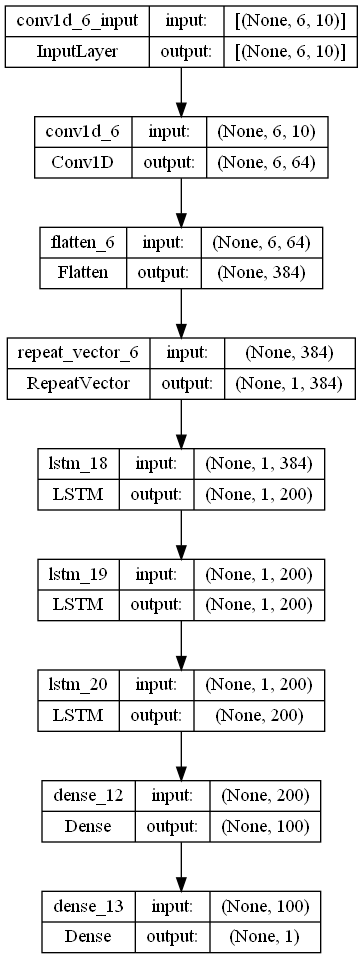

In [218]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [219]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

In [220]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
802/802 [==============================] - 51s 51ms/step - loss: 157.9667 - nse: 0.9408 - val_loss: 81.6452 - val_nse: -inf - lr: 0.0100
Epoch 2/100
802/802 [==============================] - 38s 48ms/step - loss: 92.9250 - nse: 0.9829 - val_loss: 66.5269 - val_nse: -inf - lr: 0.0100
Epoch 3/100
802/802 [==============================] - 38s 48ms/step - loss: 89.7982 - nse: 0.9842 - val_loss: 49.3295 - val_nse: -inf - lr: 0.0100
Epoch 4/100
802/802 [==============================] - 38s 48ms/step - loss: 82.8273 - nse: 0.9860 - val_loss: 53.4407 - val_nse: -inf - lr: 0.0100
Epoch 5/100
802/802 [==============================] - 38s 48ms/step - loss: 83.5074 - nse: 0.9884 - val_loss: 44.1566 - val_nse: -inf - lr: 0.0100
Epoch 6/100
802/802 [==============================] - 38s 48ms/step - loss: 74.7018 - nse: 0.9904 - val_loss: 108.7712 - val_nse: -inf - lr: 0.0100
Epoch 7/100
802/802 [==============================] - 38s 48ms/step - loss: 76.5251 - nse: 0.9892 - val_loss:

802/802 [==============================] - 40s 50ms/step - loss: 52.5366 - nse: 0.9944 - val_loss: 28.3087 - val_nse: -inf - lr: 1.9531e-05
Epoch 56/100
802/802 [==============================] - 39s 49ms/step - loss: 52.9577 - nse: 0.9939 - val_loss: 28.4837 - val_nse: -inf - lr: 1.9531e-05
Epoch 57/100
802/802 [==============================] - 40s 49ms/step - loss: 52.8504 - nse: 0.9942 - val_loss: 28.4098 - val_nse: -inf - lr: 9.7656e-06
Epoch 58/100
802/802 [==============================] - 39s 49ms/step - loss: 52.4224 - nse: 0.9943 - val_loss: 28.5071 - val_nse: -inf - lr: 9.7656e-06
Epoch 59/100
802/802 [==============================] - 40s 50ms/step - loss: 52.3448 - nse: 0.9944 - val_loss: 28.4813 - val_nse: -inf - lr: 9.7656e-06
Epoch 60/100
802/802 [==============================] - 39s 48ms/step - loss: 52.5665 - nse: 0.9942 - val_loss: 28.4179 - val_nse: -inf - lr: 4.8828e-06


In [221]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse':nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

1250/1250 [==============================] - 13s 10ms/step - loss: 17.5475 - nse: -inf


[17.547462463378906, -inf]

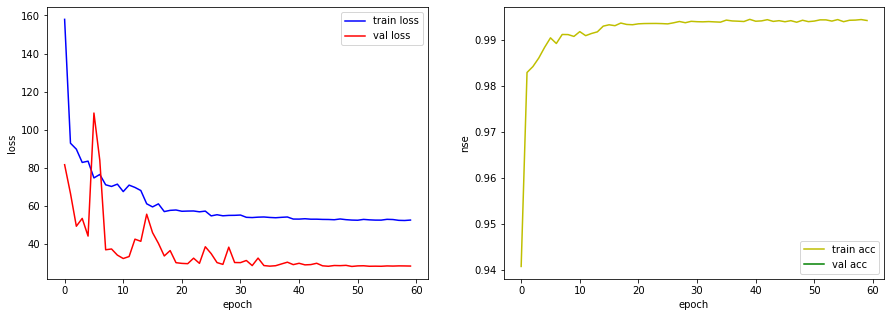

In [222]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

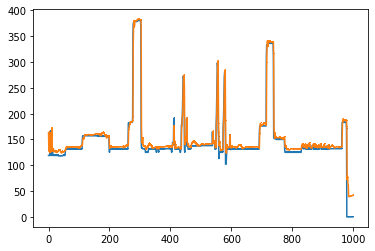

In [233]:
## 결과 시각화
tl_predict = np.array(yhat)

plt.plot(ytest[:1000], marker = ",", label = "actual")
plt.plot(tl_predict.T[0][:1000], marker = ",", label="predict", alpha = 0.98)


plt.show()

In [234]:
## 점수 확인
float(root_mean_squared_error(ytest, tl_predict))

120.68124679296139

## 파일 저장

In [235]:
raw_data2 = pd.read_csv('data/rawdata.csv')
predict_dataset = raw_data2[['방류량']]

In [236]:
predict_dataset.isnull().sum()

방류량    743
dtype: int64

In [237]:
predict_dataset.iloc[nanIndex[2]]

방류량   NaN
Name: 68083, dtype: float64

In [238]:
y_real_predict

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([na

In [239]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

24/24 [==============================] - 2s 19ms/step


In [240]:
y_real_hat

array([[ 769.33594 ],
       [ 774.1478  ],
       [ 745.366   ],
       [ 752.7827  ],
       [ 763.50586 ],
       [ 777.00964 ],
       [ 789.1633  ],
       [ 754.881   ],
       [ 759.6087  ],
       [ 767.4736  ],
       [ 778.39526 ],
       [ 793.895   ],
       [ 752.56555 ],
       [ 752.2078  ],
       [ 759.113   ],
       [ 768.3668  ],
       [ 788.5124  ],
       [ 469.17084 ],
       [ 354.4933  ],
       [ 298.21512 ],
       [ 248.49124 ],
       [ 126.863205],
       [ 126.880585],
       [ 126.153595],
       [ 126.24713 ],
       [ 127.023605],
       [ 127.84751 ],
       [ 127.664   ],
       [ 127.59753 ],
       [ 311.20105 ],
       [ 127.01094 ],
       [ 122.98786 ],
       [ 111.13416 ],
       [  79.26101 ],
       [ 131.87672 ],
       [ 131.49455 ],
       [ 127.861   ],
       [ 131.13165 ],
       [ 130.95068 ],
       [ 130.46921 ],
       [ 131.98053 ],
       [ 132.45682 ],
       [ 121.01245 ],
       [ 120.839516],
       [ 120.94445 ],
       [ 1

In [241]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   방류량     275593 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [242]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [243]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   방류량     276336 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [244]:
predict_dataset.to_csv('data/방류량.csv', index = False, encoding = 'cp949', columns = ['방류량'])

# 수위 외 결측치 처리 - 한강대교 유량

In [9]:
raw_data4 = pd.read_csv('data/방류량.csv', encoding = 'cp949')
raw_data4

,방류량
0,555.00
1,562.90
2,576.40
3,563.10
4,576.40
...,...
276331,259.23
276332,260.46
276333,259.37
276334,259.13


In [249]:
raw_data2 = pd.read_csv('data/newdata.csv', encoding = 'cp949')

In [250]:
xdata = pd.concat([raw_data,raw_data2[['강수량(mm)','강화대교_조위','청담대교_유량','한강대교_유량']],raw_data3,raw_data4], axis = 1)
xdata

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,방류량
0,310.7,300.2,290.0,275.3,0.0,445.0,469.05,729.80,540.18,555.00
1,314.7,300.2,290.0,275.3,0.0,449.0,498.00,731.48,540.18,562.90
2,313.7,301.2,290.0,275.3,0.0,451.0,490.68,726.42,540.18,576.40
3,311.7,301.2,290.0,276.3,0.0,452.0,476.21,726.42,552.17,563.10
4,311.7,301.2,291.0,277.3,0.0,450.0,476.21,707.17,564.29,576.40
...,...,...,...,...,...,...,...,...,...,...
276331,288.0,295.0,299.0,306.0,0.0,510.0,319.84,-456.41,974.40,259.23
276332,287.0,303.0,304.0,308.0,0.0,492.0,314.01,-717.30,1006.88,260.46
276333,299.0,307.0,309.0,310.0,0.0,475.0,387.55,-843.37,1039.90,259.37
276334,309.0,311.0,314.0,312.0,0.0,458.0,454.91,-1023.37,1073.46,259.13


In [251]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

In [252]:
input_x_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,방류량
0,0.049611,0.060000,0.051621,0.056478,0.0,0.118382,0.110974,0.147596,0.011070,0.057689
1,0.053502,0.060000,0.051621,0.056478,0.0,0.118713,0.112074,0.147654,0.011070,0.057984
2,0.052529,0.061111,0.051621,0.056478,0.0,0.118878,0.111796,0.147478,0.011070,0.058488
3,0.050584,0.061111,0.051621,0.058140,0.0,0.118961,0.111246,0.147478,0.011475,0.057992
4,0.050584,0.061111,0.052821,0.059801,0.0,0.118795,0.111246,0.146810,0.011883,0.058488
...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.123758,0.105305,0.106425,0.025719,0.046645
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.122269,0.105084,0.097370,0.026815,0.046691
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.120863,0.107878,0.092994,0.027929,0.046650
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.119457,0.110437,0.086747,0.029061,0.046642


In [253]:
newdata = pd.read_csv('data/rawdata.csv')
ydata = newdata[['한강대교_유량']]
ydata

,한강대교_유량
0,729.80
1,731.48
2,726.42
3,726.42
4,707.17
...,...
276331,-456.41
276332,-717.30
276333,-843.37
276334,-1023.37


In [254]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,방류량,한강대교_유량
0,0.049611,0.060000,0.051621,0.056478,0.0,0.118382,0.110974,0.147596,0.011070,0.057689,729.80
1,0.053502,0.060000,0.051621,0.056478,0.0,0.118713,0.112074,0.147654,0.011070,0.057984,731.48
2,0.052529,0.061111,0.051621,0.056478,0.0,0.118878,0.111796,0.147478,0.011070,0.058488,726.42
3,0.050584,0.061111,0.051621,0.058140,0.0,0.118961,0.111246,0.147478,0.011475,0.057992,726.42
4,0.050584,0.061111,0.052821,0.059801,0.0,0.118795,0.111246,0.146810,0.011883,0.058488,707.17
...,...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.123758,0.105305,0.106425,0.025719,0.046645,-456.41
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.122269,0.105084,0.097370,0.026815,0.046691,-717.30
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.120863,0.107878,0.092994,0.027929,0.046650,-843.37
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.119457,0.110437,0.086747,0.029061,0.046642,-1023.37


In [255]:
input_regular.isnull().sum()

청담대교_수위       0
잠수교_수위        0
한강대교_수위       0
행주대교_수위       0
강수량(mm)       0
강화대교_조위       0
청담대교_유량       0
한강대교_유량       0
행주대교_유량       0
방류량           0
한강대교_유량    1279
dtype: int64

In [256]:
idx = ydata[ydata['한강대교_유량'].isnull()==True]['한강대교_유량'].index
idx

Int64Index([ 91352,  91353,  91354,  91355,  91356,  91357,  91358,  91359,
             91360,  91361,
            ...
            262125, 262126, 262127, 262128, 262129, 262130, 262131, 262132,
            262133, 262134],
           dtype='int64', length=1279)

In [257]:
nanIndex = idx

In [258]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-len(ydata_idx)):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [03:19<00:00, 18.11s/it]


In [259]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276270, 6, 10)
(276270, 1)


In [260]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [261]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(1279, 6, 10)
(1279, 1)


In [262]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(274991, 6, 10)
(274991, 1)


In [263]:
pd.DataFrame(ydata).isnull().sum()

0    0
dtype: int64

In [264]:
xtrain = np.array(xdata[:-40000])
ytrain = np.array(ydata[:-40000])

xtest = np.array(xdata[-40000:])
ytest = np.array(ydata[-40000:])

In [265]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(234991, 6, 10)
(234991, 1)
(40000, 6, 10)
(40000, 1)


## 모델 생성

In [266]:
def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 6, 64)             1344      
                                                                 
 flatten_7 (Flatten)         (None, 384)               0         
                                                                 
 repeat_vector_7 (RepeatVect  (None, 1, 384)           0         
 or)                                                             
                                                                 
 lstm_21 (LSTM)              (None, 1, 200)            468000    
                                                                 
 lstm_22 (LSTM)              (None, 1, 200)            320800    
                                                                 
 lstm_23 (LSTM)              (None, 200)               320800    
                                                      

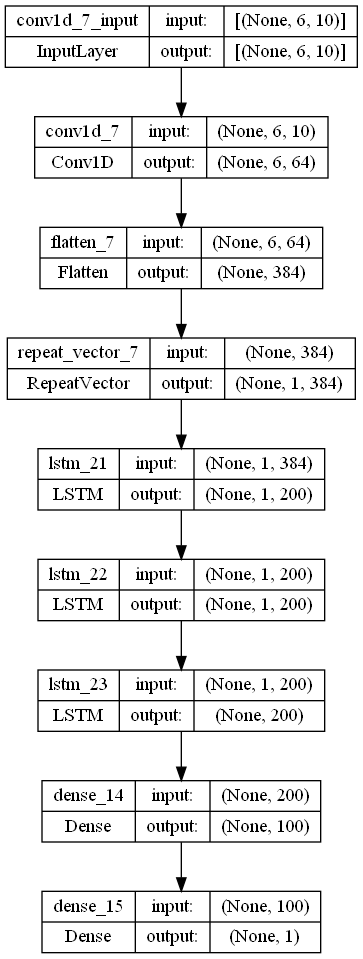

In [267]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [268]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

In [269]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
804/804 [==============================] - 25s 26ms/step - loss: 214.1825 - nse: 0.9357 - val_loss: 101.2061 - val_nse: 0.9034 - lr: 0.0100
Epoch 2/100
804/804 [==============================] - 19s 23ms/step - loss: 105.3094 - nse: 0.9893 - val_loss: 92.8842 - val_nse: 0.9095 - lr: 0.0100
Epoch 3/100
804/804 [==============================] - 19s 23ms/step - loss: 86.1457 - nse: 0.9927 - val_loss: 75.9589 - val_nse: 0.9386 - lr: 0.0100
Epoch 4/100
804/804 [==============================] - 19s 23ms/step - loss: 83.8873 - nse: 0.9929 - val_loss: 73.2657 - val_nse: 0.9322 - lr: 0.0100
Epoch 5/100
804/804 [==============================] - 20s 25ms/step - loss: 75.1533 - nse: 0.9945 - val_loss: 119.4786 - val_nse: 0.8204 - lr: 0.0100
Epoch 6/100
804/804 [==============================] - 20s 25ms/step - loss: 72.5261 - nse: 0.9950 - val_loss: 86.4538 - val_nse: 0.8852 - lr: 0.0100
Epoch 7/100
804/804 [==============================] - 19s 23ms/step - loss: 70.0665 - nse: 0.99

In [270]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse':nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

1250/1250 [==============================] - 6s 4ms/step - loss: 42.3029 - nse: 0.7637


[42.302894592285156, 0.7636547088623047]

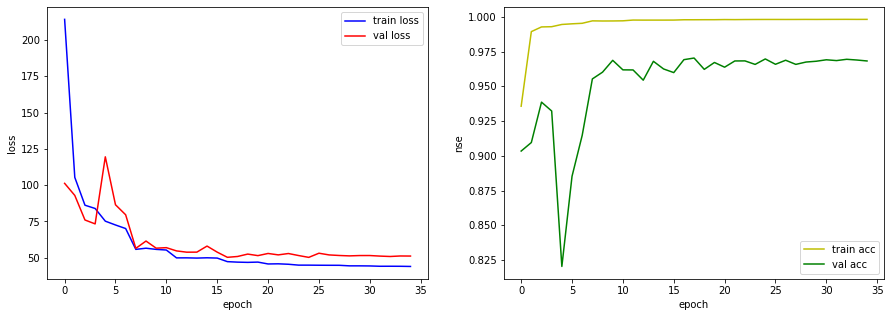

In [271]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

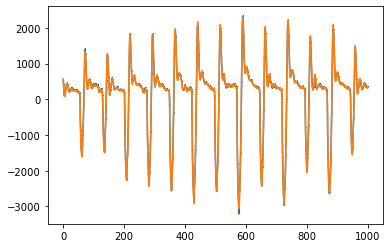

In [272]:
## 결과 시각화
tl_predict = np.array(yhat)

plt.plot(ytest[:1000], marker = ",", label = "actual")
plt.plot(tl_predict.T[0][:1000], marker = ",", label="predict", alpha = 0.98)


plt.show()

In [273]:
## 점수 확인
float(root_mean_squared_error(ytest, tl_predict))

46.53521552841579

## 파일 저장

In [274]:
raw_data2 = pd.read_csv('data/rawdata.csv')
predict_dataset = raw_data2[['한강대교_유량']]

In [275]:
predict_dataset.isnull().sum()

한강대교_유량    1279
dtype: int64

In [276]:
predict_dataset.iloc[nanIndex[2]]

한강대교_유량   NaN
Name: 91354, dtype: float64

In [277]:
y_real_predict

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([na

In [278]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

40/40 [==============================] - 1s 4ms/step


In [279]:
y_real_hat

array([[-422.4316 ],
       [-407.40195],
       [-338.65375],
       ...,
       [ 608.0371 ],
       [ 610.792  ],
       [ 595.67957]], dtype=float32)

In [280]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   한강대교_유량  275057 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [281]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [282]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   한강대교_유량  276336 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [283]:
predict_dataset.to_csv('data/한강대교_유량.csv', index = False, encoding = 'cp949', columns = ['한강대교_유량'])

# 수위 외 결측치 처리 - 강화대교 조위

In [10]:
raw_data5 = pd.read_csv('data/한강대교_유량.csv', encoding = 'cp949')
raw_data5

,한강대교_유량
0,729.80
1,731.48
2,726.42
3,726.42
4,707.17
...,...
276331,-456.41
276332,-717.30
276333,-843.37
276334,-1023.37


In [285]:
raw_data2 = pd.read_csv('data/newdata.csv', encoding = 'cp949')

In [286]:
xdata = pd.concat([raw_data,raw_data2[['강수량(mm)','강화대교_조위','청담대교_유량']],raw_data3,raw_data4, raw_data5], axis = 1)
xdata

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),강화대교_조위,청담대교_유량,행주대교_유량,방류량,한강대교_유량
0,310.7,300.2,290.0,275.3,0.0,445.0,469.05,540.18,555.00,729.80
1,314.7,300.2,290.0,275.3,0.0,449.0,498.00,540.18,562.90,731.48
2,313.7,301.2,290.0,275.3,0.0,451.0,490.68,540.18,576.40,726.42
3,311.7,301.2,290.0,276.3,0.0,452.0,476.21,552.17,563.10,726.42
4,311.7,301.2,291.0,277.3,0.0,450.0,476.21,564.29,576.40,707.17
...,...,...,...,...,...,...,...,...,...,...
276331,288.0,295.0,299.0,306.0,0.0,510.0,319.84,974.40,259.23,-456.41
276332,287.0,303.0,304.0,308.0,0.0,492.0,314.01,1006.88,260.46,-717.30
276333,299.0,307.0,309.0,310.0,0.0,475.0,387.55,1039.90,259.37,-843.37
276334,309.0,311.0,314.0,312.0,0.0,458.0,454.91,1073.46,259.13,-1023.37


In [287]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

In [288]:
input_x_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),강화대교_조위,청담대교_유량,행주대교_유량,방류량,한강대교_유량
0,0.049611,0.060000,0.051621,0.056478,0.0,0.118382,0.110974,0.011070,0.057689,0.147596
1,0.053502,0.060000,0.051621,0.056478,0.0,0.118713,0.112074,0.011070,0.057984,0.147654
2,0.052529,0.061111,0.051621,0.056478,0.0,0.118878,0.111796,0.011070,0.058488,0.147478
3,0.050584,0.061111,0.051621,0.058140,0.0,0.118961,0.111246,0.011475,0.057992,0.147478
4,0.050584,0.061111,0.052821,0.059801,0.0,0.118795,0.111246,0.011883,0.058488,0.146810
...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.123758,0.105305,0.025719,0.046645,0.106425
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.122269,0.105084,0.026815,0.046691,0.097370
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.120863,0.107878,0.027929,0.046650,0.092994
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.119457,0.110437,0.029061,0.046642,0.086747


In [289]:
newdata = pd.read_csv('data/rawdata.csv')
ydata = newdata[['강화대교_조위']]
ydata

,강화대교_조위
0,445.0
1,449.0
2,451.0
3,452.0
4,450.0
...,...
276331,510.0
276332,492.0
276333,475.0
276334,458.0


In [290]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),강화대교_조위,청담대교_유량,행주대교_유량,방류량,한강대교_유량,강화대교_조위
0,0.049611,0.060000,0.051621,0.056478,0.0,0.118382,0.110974,0.011070,0.057689,0.147596,445.0
1,0.053502,0.060000,0.051621,0.056478,0.0,0.118713,0.112074,0.011070,0.057984,0.147654,449.0
2,0.052529,0.061111,0.051621,0.056478,0.0,0.118878,0.111796,0.011070,0.058488,0.147478,451.0
3,0.050584,0.061111,0.051621,0.058140,0.0,0.118961,0.111246,0.011475,0.057992,0.147478,452.0
4,0.050584,0.061111,0.052821,0.059801,0.0,0.118795,0.111246,0.011883,0.058488,0.146810,450.0
...,...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.123758,0.105305,0.025719,0.046645,0.106425,510.0
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.122269,0.105084,0.026815,0.046691,0.097370,492.0
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.120863,0.107878,0.027929,0.046650,0.092994,475.0
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.119457,0.110437,0.029061,0.046642,0.086747,458.0


In [291]:
input_regular.isnull().sum()

청담대교_수위       0
잠수교_수위        0
한강대교_수위       0
행주대교_수위       0
강수량(mm)       0
강화대교_조위       0
청담대교_유량       0
행주대교_유량       0
방류량           0
한강대교_유량       0
강화대교_조위    4927
dtype: int64

In [292]:
idx = ydata[ydata['강화대교_조위'].isnull()==True]['강화대교_조위'].index
idx

Int64Index([   193,    307,   1359,   1377,   1378,   1379,   1380,   1381,
              1382,   1383,
            ...
            265027, 265028, 265029, 266199, 266290, 267172, 270004, 270383,
            272504, 274258],
           dtype='int64', length=4927)

In [293]:
nanIndex = idx

In [294]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-len(ydata_idx)):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:37<00:00,  8.85s/it]


In [295]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276270, 6, 10)
(276270, 1)


In [296]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [297]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(4927, 6, 10)
(4927, 1)


In [298]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(271343, 6, 10)
(271343, 1)


In [299]:
pd.DataFrame(ydata).isnull().sum()

0    0
dtype: int64

In [300]:
xtrain = np.array(xdata[:-40000])
ytrain = np.array(ydata[:-40000])

xtest = np.array(xdata[-40000:])
ytest = np.array(ydata[-40000:])

In [301]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(231343, 6, 10)
(231343, 1)
(40000, 6, 10)
(40000, 1)


## 모델 생성

In [302]:
def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 6, 64)             1344      
                                                                 
 flatten_8 (Flatten)         (None, 384)               0         
                                                                 
 repeat_vector_8 (RepeatVect  (None, 1, 384)           0         
 or)                                                             
                                                                 
 lstm_24 (LSTM)              (None, 1, 200)            468000    
                                                                 
 lstm_25 (LSTM)              (None, 1, 200)            320800    
                                                                 
 lstm_26 (LSTM)              (None, 200)               320800    
                                                      

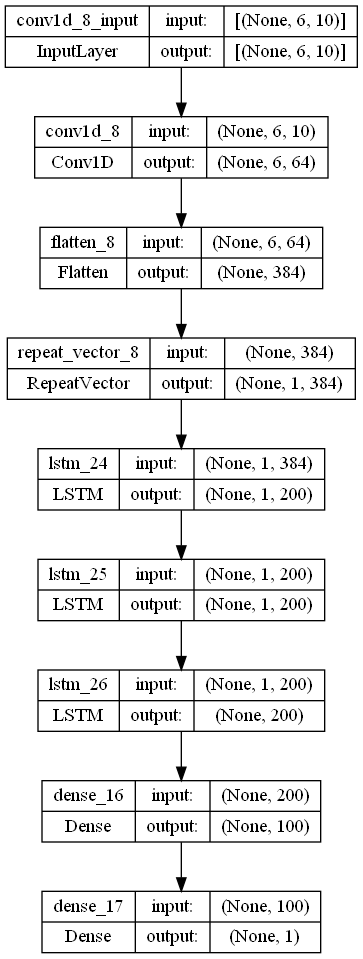

In [303]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [304]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

In [305]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
802/802 [==============================] - 29s 31ms/step - loss: 64.6723 - nse: 0.7618 - val_loss: 26.9530 - val_nse: 0.9645 - lr: 0.0100
Epoch 2/100
802/802 [==============================] - 24s 29ms/step - loss: 30.0847 - nse: 0.9567 - val_loss: 37.4487 - val_nse: 0.9418 - lr: 0.0100
Epoch 3/100
802/802 [==============================] - 24s 29ms/step - loss: 23.7450 - nse: 0.9738 - val_loss: 74.3478 - val_nse: 0.7902 - lr: 0.0100
Epoch 4/100
802/802 [==============================] - 23s 29ms/step - loss: 18.5828 - nse: 0.9853 - val_loss: 26.9859 - val_nse: 0.9685 - lr: 0.0100
Epoch 5/100
802/802 [==============================] - 24s 29ms/step - loss: 9.5178 - nse: 0.9960 - val_loss: 7.2704 - val_nse: 0.9969 - lr: 0.0050
Epoch 6/100
802/802 [==============================] - 23s 29ms/step - loss: 9.0440 - nse: 0.9961 - val_loss: 5.4825 - val_nse: 0.9985 - lr: 0.0050
Epoch 7/100
802/802 [==============================] - 23s 29ms/step - loss: 11.2377 - nse: 0.9943 - val

In [306]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse':nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

1250/1250 [==============================] - 6s 5ms/step - loss: 2.1634 - nse: 0.9992


[2.163403272628784, 0.9991748929023743]

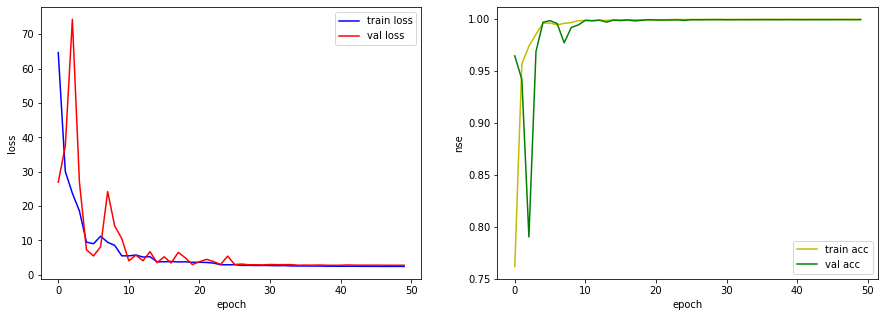

In [307]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

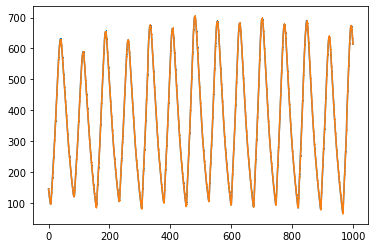

In [308]:
## 결과 시각화
tl_predict = np.array(yhat)

plt.plot(ytest[:1000], marker = ",", label = "actual")
plt.plot(tl_predict.T[0][:1000], marker = ",", label="predict", alpha = 0.98)


plt.show()

In [309]:
## 점수 확인
float(root_mean_squared_error(ytest, tl_predict))

2.4342167323209174

## 파일 저장

In [310]:
raw_data2 = pd.read_csv('data/rawdata.csv')
predict_dataset = raw_data2[['강화대교_조위']]

In [311]:
predict_dataset.isnull().sum()

강화대교_조위    4927
dtype: int64

In [312]:
predict_dataset.iloc[nanIndex[2]]

강화대교_조위   NaN
Name: 1359, dtype: float64

In [313]:
y_real_predict

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([na

In [314]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

154/154 [==============================] - 1s 5ms/step


In [315]:
y_real_hat

array([[131.65527],
       [556.96875],
       [582.6185 ],
       ...,
       [235.86409],
       [326.25107],
       [277.9791 ]], dtype=float32)

In [316]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   강화대교_조위  271409 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [317]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [318]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   강화대교_조위  276336 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [319]:
predict_dataset.to_csv('data/강화대교_조위.csv', index = False, encoding = 'cp949', columns = ['강화대교_조위'])

# 수위 외 결측치 처리 - 청담대교 유량

In [11]:
raw_data6 = pd.read_csv('data/강화대교_조위.csv', encoding = 'cp949')
raw_data6

,강화대교_조위
0,445.0
1,449.0
2,451.0
3,452.0
4,450.0
...,...
276331,510.0
276332,492.0
276333,475.0
276334,458.0


In [321]:
raw_data2 = pd.read_csv('data/newdata.csv', encoding = 'cp949')

In [322]:
xdata = pd.concat([raw_data,raw_data2[['강수량(mm)','청담대교_유량']],raw_data3,raw_data4, raw_data5,raw_data6], axis = 1)
xdata

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),청담대교_유량,행주대교_유량,방류량,한강대교_유량,강화대교_조위
0,310.7,300.2,290.0,275.3,0.0,469.05,540.18,555.00,729.80,445.0
1,314.7,300.2,290.0,275.3,0.0,498.00,540.18,562.90,731.48,449.0
2,313.7,301.2,290.0,275.3,0.0,490.68,540.18,576.40,726.42,451.0
3,311.7,301.2,290.0,276.3,0.0,476.21,552.17,563.10,726.42,452.0
4,311.7,301.2,291.0,277.3,0.0,476.21,564.29,576.40,707.17,450.0
...,...,...,...,...,...,...,...,...,...,...
276331,288.0,295.0,299.0,306.0,0.0,319.84,974.40,259.23,-456.41,510.0
276332,287.0,303.0,304.0,308.0,0.0,314.01,1006.88,260.46,-717.30,492.0
276333,299.0,307.0,309.0,310.0,0.0,387.55,1039.90,259.37,-843.37,475.0
276334,309.0,311.0,314.0,312.0,0.0,454.91,1073.46,259.13,-1023.37,458.0


In [323]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

In [324]:
input_x_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),청담대교_유량,행주대교_유량,방류량,한강대교_유량,강화대교_조위
0,0.049611,0.060000,0.051621,0.056478,0.0,0.110974,0.011070,0.057689,0.147596,0.374042
1,0.053502,0.060000,0.051621,0.056478,0.0,0.112074,0.011070,0.057984,0.147654,0.377714
2,0.052529,0.061111,0.051621,0.056478,0.0,0.111796,0.011070,0.058488,0.147478,0.379550
3,0.050584,0.061111,0.051621,0.058140,0.0,0.111246,0.011475,0.057992,0.147478,0.380468
4,0.050584,0.061111,0.052821,0.059801,0.0,0.111246,0.011883,0.058488,0.146810,0.378632
...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.105305,0.025719,0.046645,0.106425,0.433715
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.105084,0.026815,0.046691,0.097370,0.417190
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.107878,0.027929,0.046650,0.092994,0.401583
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.110437,0.029061,0.046642,0.086747,0.385976


In [325]:
newdata = pd.read_csv('data/rawdata.csv')
ydata = newdata[['청담대교_유량']]
ydata

,청담대교_유량
0,469.05
1,498.00
2,490.68
3,476.21
4,476.21
...,...
276331,319.84
276332,314.01
276333,387.55
276334,454.91


In [326]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),청담대교_유량,행주대교_유량,방류량,한강대교_유량,강화대교_조위,청담대교_유량
0,0.049611,0.060000,0.051621,0.056478,0.0,0.110974,0.011070,0.057689,0.147596,0.374042,469.05
1,0.053502,0.060000,0.051621,0.056478,0.0,0.112074,0.011070,0.057984,0.147654,0.377714,498.00
2,0.052529,0.061111,0.051621,0.056478,0.0,0.111796,0.011070,0.058488,0.147478,0.379550,490.68
3,0.050584,0.061111,0.051621,0.058140,0.0,0.111246,0.011475,0.057992,0.147478,0.380468,476.21
4,0.050584,0.061111,0.052821,0.059801,0.0,0.111246,0.011883,0.058488,0.146810,0.378632,476.21
...,...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.105305,0.025719,0.046645,0.106425,0.433715,319.84
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.105084,0.026815,0.046691,0.097370,0.417190,314.01
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.107878,0.027929,0.046650,0.092994,0.401583,387.55
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.110437,0.029061,0.046642,0.086747,0.385976,454.91


In [327]:
input_regular.isnull().sum()

청담대교_수위        0
잠수교_수위         0
한강대교_수위        0
행주대교_수위        0
강수량(mm)        0
청담대교_유량        0
행주대교_유량        0
방류량            0
한강대교_유량        0
강화대교_조위        0
청담대교_유량    16380
dtype: int64

In [328]:
idx = ydata[ydata['청담대교_유량'].isnull()==True]['청담대교_유량'].index
idx

Int64Index([ 80994,  80995,  80996,  80997,  80998,  80999,  81000,  81001,
             81002,  81003,
            ...
            273770, 273771, 273772, 273773, 273774, 273775, 273776, 273777,
            273778, 273779],
           dtype='int64', length=16380)

In [329]:
nanIndex = idx

In [330]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-len(ydata_idx)):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:39<00:00,  9.06s/it]


In [331]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276270, 6, 10)
(276270, 1)


In [332]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [333]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(16380, 6, 10)
(16380, 1)


In [334]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(259890, 6, 10)
(259890, 1)


In [335]:
pd.DataFrame(ydata).isnull().sum()

0    0
dtype: int64

In [336]:
xtrain = np.array(xdata[:-40000])
ytrain = np.array(ydata[:-40000])

xtest = np.array(xdata[-40000:])
ytest = np.array(ydata[-40000:])

In [337]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(219890, 6, 10)
(219890, 1)
(40000, 6, 10)
(40000, 1)


## 모델 생성

In [338]:
def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 6, 64)             1344      
                                                                 
 flatten_9 (Flatten)         (None, 384)               0         
                                                                 
 repeat_vector_9 (RepeatVect  (None, 1, 384)           0         
 or)                                                             
                                                                 
 lstm_27 (LSTM)              (None, 1, 200)            468000    
                                                                 
 lstm_28 (LSTM)              (None, 1, 200)            320800    
                                                                 
 lstm_29 (LSTM)              (None, 200)               320800    
                                                      

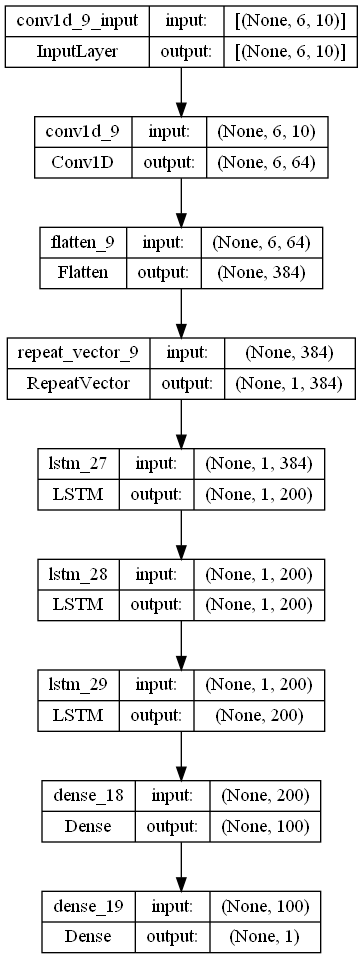

In [339]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [340]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

In [341]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
804/804 [==============================] - 38s 40ms/step - loss: 134.6102 - nse: 0.9553 - val_loss: 68.7916 - val_nse: 0.8104 - lr: 0.0100
Epoch 2/100
804/804 [==============================] - 32s 39ms/step - loss: 85.0335 - nse: 0.9877 - val_loss: 92.4545 - val_nse: -0.5450 - lr: 0.0100
Epoch 3/100
804/804 [==============================] - 31s 39ms/step - loss: 67.4624 - nse: 0.9919 - val_loss: 40.3458 - val_nse: 0.9007 - lr: 0.0100
Epoch 4/100
804/804 [==============================] - 31s 39ms/step - loss: 61.2774 - nse: 0.9936 - val_loss: 63.5854 - val_nse: 0.3779 - lr: 0.0100
Epoch 5/100
804/804 [==============================] - 32s 39ms/step - loss: 55.4871 - nse: 0.9947 - val_loss: 55.0550 - val_nse: 0.5842 - lr: 0.0100
Epoch 6/100
804/804 [==============================] - 32s 40ms/step - loss: 50.2955 - nse: 0.9960 - val_loss: 23.9326 - val_nse: 0.9459 - lr: 0.0100
Epoch 7/100
804/804 [==============================] - 31s 39ms/step - loss: 50.0083 - nse: 0.9957

In [342]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse':nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

1250/1250 [==============================] - 26s 19ms/step - loss: 15.6026 - nse: 0.3410


[15.602566719055176, 0.34102684259414673]

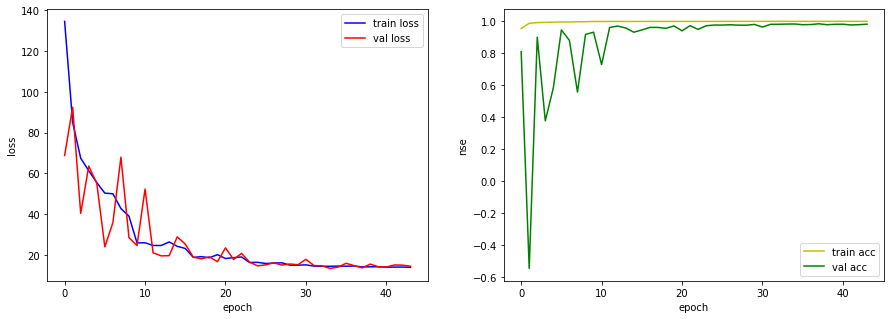

In [343]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

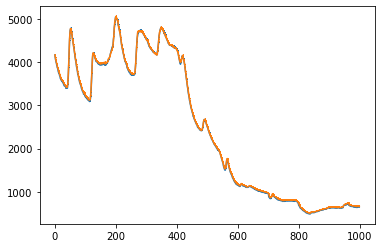

In [344]:
## 결과 시각화
tl_predict = np.array(yhat)

plt.plot(ytest[:1000], marker = ",", label = "actual")
plt.plot(tl_predict.T[0][:1000], marker = ",", label="predict", alpha = 0.98)


plt.show()

In [345]:
## 점수 확인
float(root_mean_squared_error(ytest, tl_predict))

31.51980254935077

## 파일 저장

In [346]:
raw_data2 = pd.read_csv('data/rawdata.csv')
predict_dataset = raw_data2[['청담대교_유량']]

In [347]:
predict_dataset.isnull().sum()

청담대교_유량    16380
dtype: int64

In [348]:
predict_dataset.iloc[nanIndex[2]]

청담대교_유량   NaN
Name: 80996, dtype: float64

In [349]:
y_real_predict

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([na

In [350]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

512/512 [==============================] - 11s 18ms/step


In [351]:
y_real_hat

array([[  245.97386],
       [  244.71916],
       [  244.81357],
       ...,
       [14273.685  ],
       [14277.601  ],
       [14279.1875 ]], dtype=float32)

In [352]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   청담대교_유량  259956 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [353]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [354]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   청담대교_유량  276336 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [355]:
predict_dataset.to_csv('data/청담대교_유량.csv', index = False, encoding = 'cp949', columns = ['청담대교_유량'])

# 수위 외 결측치 처리 - 광진교 수위

In [12]:
raw_data7 = pd.read_csv('data/청담대교_유량.csv', encoding = 'cp949')
raw_data7

,청담대교_유량
0,469.05
1,498.00
2,490.68
3,476.21
4,476.21
...,...
276331,319.84
276332,314.01
276333,387.55
276334,454.91


In [13]:
raw_data2 = pd.read_csv('data/newdata.csv', encoding = 'cp949')

In [14]:
xdata = pd.concat([raw_data,raw_data2[['강수량(mm)','광진교_수위']],raw_data3,raw_data4, raw_data5,raw_data6,raw_data7], axis = 1)
xdata

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),광진교_수위,행주대교_유량,방류량,한강대교_유량,강화대교_조위,청담대교_유량
0,310.7,300.2,290.0,275.3,0.0,1.20,540.18,555.00,729.80,445.0,469.05
1,314.7,300.2,290.0,275.3,0.0,1.20,540.18,562.90,731.48,449.0,498.00
2,313.7,301.2,290.0,275.3,0.0,1.20,540.18,576.40,726.42,451.0,490.68
3,311.7,301.2,290.0,276.3,0.0,1.20,552.17,563.10,726.42,452.0,476.21
4,311.7,301.2,291.0,277.3,0.0,1.20,564.29,576.40,707.17,450.0,476.21
...,...,...,...,...,...,...,...,...,...,...,...
276331,288.0,295.0,299.0,306.0,0.0,1.12,974.40,259.23,-456.41,510.0,319.84
276332,287.0,303.0,304.0,308.0,0.0,1.12,1006.88,260.46,-717.30,492.0,314.01
276333,299.0,307.0,309.0,310.0,0.0,1.12,1039.90,259.37,-843.37,475.0,387.55
276334,309.0,311.0,314.0,312.0,0.0,1.12,1073.46,259.13,-1023.37,458.0,454.91


In [15]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

In [16]:
input_x_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),광진교_수위,행주대교_유량,방류량,한강대교_유량,강화대교_조위,청담대교_유량
0,0.049611,0.060000,0.051621,0.056478,0.0,0.056452,0.011070,0.057689,0.147596,0.374042,0.017323
1,0.053502,0.060000,0.051621,0.056478,0.0,0.056452,0.011070,0.057984,0.147654,0.377714,0.019365
2,0.052529,0.061111,0.051621,0.056478,0.0,0.056452,0.011070,0.058488,0.147478,0.379550,0.018849
3,0.050584,0.061111,0.051621,0.058140,0.0,0.056452,0.011475,0.057992,0.147478,0.380468,0.017828
4,0.050584,0.061111,0.052821,0.059801,0.0,0.056452,0.011883,0.058488,0.146810,0.378632,0.017828
...,...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.045699,0.025719,0.046645,0.106425,0.433715,0.006797
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.045699,0.026815,0.046691,0.097370,0.417190,0.006386
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.045699,0.027929,0.046650,0.092994,0.401583,0.011574
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.045699,0.029061,0.046642,0.086747,0.385976,0.016326


In [18]:
newdata = pd.read_csv('data/외부데이터/광진교_수위.csv', encoding = 'cp949')
ydata = newdata[['광진교_수위']]
ydata

,광진교_수위
0,1.2
1,1.2
2,1.2
3,1.2
4,1.2
...,...
276331,1.12
276332,1.12
276333,1.12
276334,1.12


In [21]:
idx = ydata[ydata['광진교_수위'] == '-']['광진교_수위'].index
idx

Int64Index([140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620,
            140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628,
            140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636,
            140637, 140638, 140639, 140640, 140641, 140642, 140643, 140644,
            140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652,
            140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660,
            140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668,
            140669, 140670, 236080],
           dtype='int64')

In [22]:
import numpy as np
for i in idx:
    ydata.loc[i,'광진교_수위']=np.NaN
ydata

,광진교_수위
0,1.2
1,1.2
2,1.2
3,1.2
4,1.2
...,...
276331,1.12
276332,1.12
276333,1.12
276334,1.12


In [23]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,강수량(mm),광진교_수위,행주대교_유량,방류량,한강대교_유량,강화대교_조위,청담대교_유량,광진교_수위
0,0.049611,0.060000,0.051621,0.056478,0.0,0.056452,0.011070,0.057689,0.147596,0.374042,0.017323,1.2
1,0.053502,0.060000,0.051621,0.056478,0.0,0.056452,0.011070,0.057984,0.147654,0.377714,0.019365,1.2
2,0.052529,0.061111,0.051621,0.056478,0.0,0.056452,0.011070,0.058488,0.147478,0.379550,0.018849,1.2
3,0.050584,0.061111,0.051621,0.058140,0.0,0.056452,0.011475,0.057992,0.147478,0.380468,0.017828,1.2
4,0.050584,0.061111,0.052821,0.059801,0.0,0.056452,0.011883,0.058488,0.146810,0.378632,0.017828,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...
276331,0.027529,0.054222,0.062425,0.107475,0.0,0.045699,0.025719,0.046645,0.106425,0.433715,0.006797,1.12
276332,0.026556,0.063111,0.068427,0.110797,0.0,0.045699,0.026815,0.046691,0.097370,0.417190,0.006386,1.12
276333,0.038230,0.067556,0.074430,0.114120,0.0,0.045699,0.027929,0.046650,0.092994,0.401583,0.011574,1.12
276334,0.047957,0.072000,0.080432,0.117442,0.0,0.045699,0.029061,0.046642,0.086747,0.385976,0.016326,1.12


In [24]:
input_regular.isnull().sum()

청담대교_수위     0
잠수교_수위      0
한강대교_수위     0
행주대교_수위     0
강수량(mm)     0
광진교_수위      0
행주대교_유량     0
방류량         0
한강대교_유량     0
강화대교_조위     0
청담대교_유량     0
광진교_수위     59
dtype: int64

In [25]:
idx = ydata[ydata['광진교_수위'].isnull()==True]['광진교_수위'].index
idx

Int64Index([140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620,
            140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628,
            140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636,
            140637, 140638, 140639, 140640, 140641, 140642, 140643, 140644,
            140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652,
            140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660,
            140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668,
            140669, 140670, 236080],
           dtype='int64')

In [26]:
nanIndex = idx

In [27]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-len(ydata_idx)):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:37<00:00,  8.82s/it]


In [28]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276270, 6, 11)
(276270, 1)


In [29]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [30]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(59, 6, 11)
(59, 1)


In [31]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276211, 6, 11)
(276211, 1)


In [32]:
pd.DataFrame(ydata).isnull().sum()

0    0
dtype: int64

In [33]:
xtrain = np.array(xdata[:-40000])
ytrain = np.array(ydata[:-40000])

xtest = np.array(xdata[-40000:])
ytest = np.array(ydata[-40000:])

In [34]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(236211, 6, 11)
(236211, 1)
(40000, 6, 11)
(40000, 1)


## 모델 생성

In [35]:
def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             1472      
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 384)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 200)            468000    
                                                                 
 lstm_1 (LSTM)               (None, 1, 200)            320800    
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                        

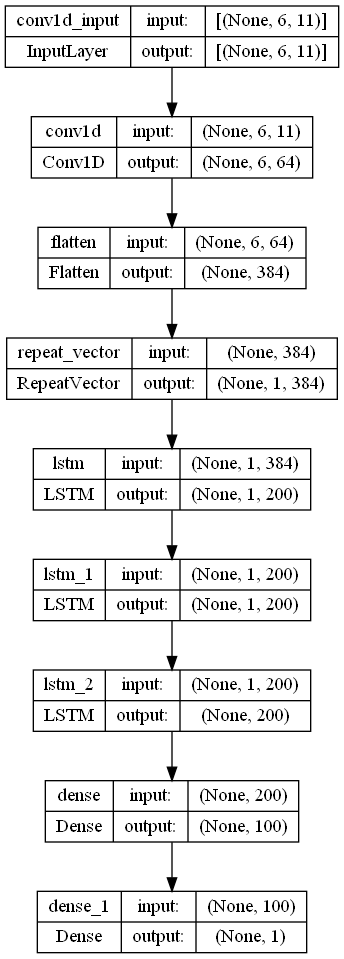

In [36]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [37]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

In [38]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
801/801 [==============================] - 20s 19ms/step - loss: 0.0648 - nse: 0.7086 - val_loss: 0.0255 - val_nse: -61586028.0000 - lr: 0.0100
Epoch 2/100
801/801 [==============================] - 17s 22ms/step - loss: 0.0259 - nse: 0.9853 - val_loss: 0.0900 - val_nse: -2324682240.0000 - lr: 0.0100
Epoch 3/100
801/801 [==============================] - 20s 25ms/step - loss: 0.0200 - nse: 0.9911 - val_loss: 0.0226 - val_nse: -102228240.0000 - lr: 0.0100
Epoch 4/100
801/801 [==============================] - 19s 24ms/step - loss: 0.0190 - nse: 0.9920 - val_loss: 0.0239 - val_nse: -31176648.0000 - lr: 0.0100
Epoch 5/100
801/801 [==============================] - 19s 24ms/step - loss: 0.0172 - nse: 0.9930 - val_loss: 0.0173 - val_nse: -5375788.0000 - lr: 0.0100
Epoch 6/100
801/801 [==============================] - 19s 24ms/step - loss: 0.0144 - nse: 0.9954 - val_loss: 0.0172 - val_nse: -94623416.0000 - lr: 0.0100
Epoch 7/100
801/801 [==============================] - 19s 24m

In [39]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse':nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

1250/1250 [==============================] - 7s 5ms/step - loss: 0.0065 - nse: -inf


[0.006504676770418882, -inf]

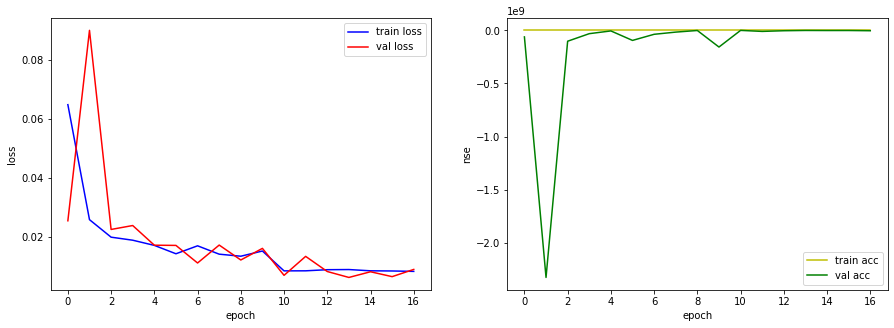

In [40]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

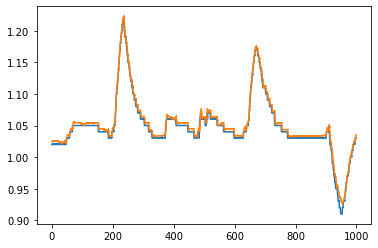

In [41]:
## 결과 시각화
tl_predict = np.array(yhat)

plt.plot(ytest[:1000], marker = ",", label = "actual")
plt.plot(tl_predict.T[0][:1000], marker = ",", label="predict", alpha = 0.98)


plt.show()

In [42]:
## 점수 확인
float(root_mean_squared_error(ytest, tl_predict))

0.009270081071076755

## 파일 저장

In [46]:
newdata = pd.read_csv('data/외부데이터/광진교_수위.csv', encoding = 'cp949')
predict_dataset = newdata[['광진교_수위']]

idx = newdata[newdata['광진교_수위'] == '-']['광진교_수위'].index

import numpy as np
for i in idx:
    newdata.loc[i,'광진교_수위']=np.NaN
predict_dataset = newdata[['광진교_수위']]

In [47]:
predict_dataset.isnull().sum()

광진교_수위    59
dtype: int64

In [48]:
predict_dataset.iloc[nanIndex[2]]

광진교_수위    NaN
Name: 140615, dtype: object

In [49]:
y_real_predict

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan])]

In [50]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

2/2 [==============================] - 0s 5ms/step


In [51]:
y_real_hat

array([[0.9816177 ],
       [0.981897  ],
       [0.9819056 ],
       [0.9815781 ],
       [0.98090386],
       [0.97997886],
       [0.97936314],
       [0.9789423 ],
       [0.97874296],
       [0.9783783 ],
       [0.9780024 ],
       [0.9777158 ],
       [0.97739613],
       [0.977113  ],
       [0.97690934],
       [0.9767588 ],
       [0.9766209 ],
       [0.9766004 ],
       [0.9764542 ],
       [0.9762924 ],
       [0.97614694],
       [0.97586054],
       [0.97556746],
       [0.975381  ],
       [0.9750755 ],
       [0.97468185],
       [0.9744627 ],
       [0.97433597],
       [0.9741786 ],
       [0.97408134],
       [0.9740828 ],
       [0.97409546],
       [0.9740062 ],
       [0.97396016],
       [0.97424084],
       [0.9747415 ],
       [0.97536933],
       [0.9758918 ],
       [0.97619647],
       [0.97642684],
       [0.97664857],
       [0.9770886 ],
       [0.9777279 ],
       [0.97848225],
       [0.97914463],
       [0.97980076],
       [0.98081374],
       [0.981

In [52]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   광진교_수위  276277 non-null  object
dtypes: object(1)
memory usage: 2.1+ MB


In [53]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [54]:
predict_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   광진교_수위  276336 non-null  object
dtypes: object(1)
memory usage: 2.1+ MB


In [55]:
predict_dataset.to_csv('data/광진교_수위.csv', index = False, encoding = 'cp949', columns = ['광진교_수위'])